# Enhanced Stamp Detection (StaVer) – Improved CNN with Advanced Features

- Prepared by: kandil safouane / II-CCN3
- Spec: Advanced Deep Learning for Document Analysis


# PROJECT OVERVIEW

Key Features:

- Data Augmentation: Random rotations, flips, brightness adjustments
- Deeper U-Net: More filters and layers for better feature extraction
- Advanced Callbacks: Learning rate scheduling + TensorBoard logging
- Better Metrics: Dice coefficient + F1 score alongside IoU
- Higher Resolution: 512×512 instead of 256×256 for finer details
- Batch Normalization: Faster convergence and better generalization

Dataset Info:

- Source: StaVer Dataset (Kaggle)
- Size: 400 scanned documents at 200 DPI
- Task: Pixel-level stamp segmentation (binary masks)
- Split: 320 train | 40 validation | 40 test


## Setup and Installation

This section installs all required dependencies for the project


In [ ]:
!pip install -q kagglehub tensorflow matplotlib scikit-learn seaborn opencv-python

## Import Libraries


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import jaccard_score
import kagglehub
import shutil
import cv2
from google.colab import files

print("=" * 70)
print("SYSTEM CHECK")
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU Available: {gpu_devices[0].name}")
else:
    print("No GPU detected")
print("=" * 70)

# Set random seeds for reproducibility
tf.random.set_seed(2024)
np.random.seed(2024)

print("\nAll libraries imported successfully!")


SYSTEM CHECK
TensorFlow version: 2.19.0
✅ GPU Available: /physical_device:GPU:0
   Training will be FAST! 🚀

✅ All libraries imported successfully!


## Download Dataset

Downloads the StaVer dataset from Kaggle using kagglehub (no API key needed)


In [ ]:
print("\n" + "=" * 70)
print("DOWNLOADING DATASET")
print("=" * 70)

path = kagglehub.dataset_download("rtatman/stamp-verification-staver-dataset")
print(f"Downloaded to: {path}")

target = "/content/staver_data"
if not os.path.exists("/content/staver_data"):
  if os.path.exists(target):
      shutil.rmtree(target)
  shutil.copytree(path, target)
  print(f"Copied to: {target}")
  print("=" * 70)



📥 DOWNLOADING DATASET
Using Colab cache for faster access to the 'stamp-verification-staver-dataset' dataset.
✅ Downloaded to: /kaggle/input/stamp-verification-staver-dataset


## Fix Nested Folder Structure

The dataset has duplicate nested folders - this function flattens them


In [ ]:
def flatten_duplicate_folders(root):
    """
    Fixes the StaVer dataset's nested folder structure.
    Problem: Dataset has folders like scans/scans/images.png
    Solution: Move files from nested folders up to parent directories
    """
    name_to_paths = {}

    # Find all folders with same name at different depths
    for dirpath, _, _ in os.walk(root):
        name = os.path.basename(dirpath)
        name_to_paths.setdefault(name, []).append(dirpath)

    # Process each set of duplicate folder names
    for name, paths in name_to_paths.items():
        if len(paths) <= 1:
            continue

        print(f"\nFixing duplicate: '{name}' - {len(paths)} copies found")

        # Score each path by number of files
        scored = []
        for p in paths:
            file_list = [f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))]
            scored.append((len(file_list), p))

        scored.sort(reverse=True)

        # Find nested folder with files and its parent
        nested_with_files = None
        parent_candidate = None

        for score, p in scored:
            if score > 0:
                nested_with_files = p
                parent_candidate = os.path.dirname(p)
                if parent_candidate == root or os.path.basename(parent_candidate) == name:
                    break

        # Move files from nested to parent
        if nested_with_files and parent_candidate:
            print(f"  Moving files: {os.path.basename(nested_with_files)} to {os.path.basename(parent_candidate)}")
            for f in os.listdir(nested_with_files):
                src = os.path.join(nested_with_files, f)
                dst = os.path.join(parent_candidate, f)
                if os.path.exists(src):
                    shutil.move(src, dst)

            # Clean up empty nested folder
            shutil.rmtree(nested_with_files)
            print(f"  Cleaned up nested folder")

print("\n" + "=" * 70)
print("FIXING FOLDER STRUCTURE")
print("=" * 70)
flatten_duplicate_folders(target)
print("\nDataset structure fixed!")
print("=" * 70)



🔧 FIXING FOLDER STRUCTURE

✅ Dataset structure fixed!


## Visualize Sample Images



SAMPLE VISUALIZATION


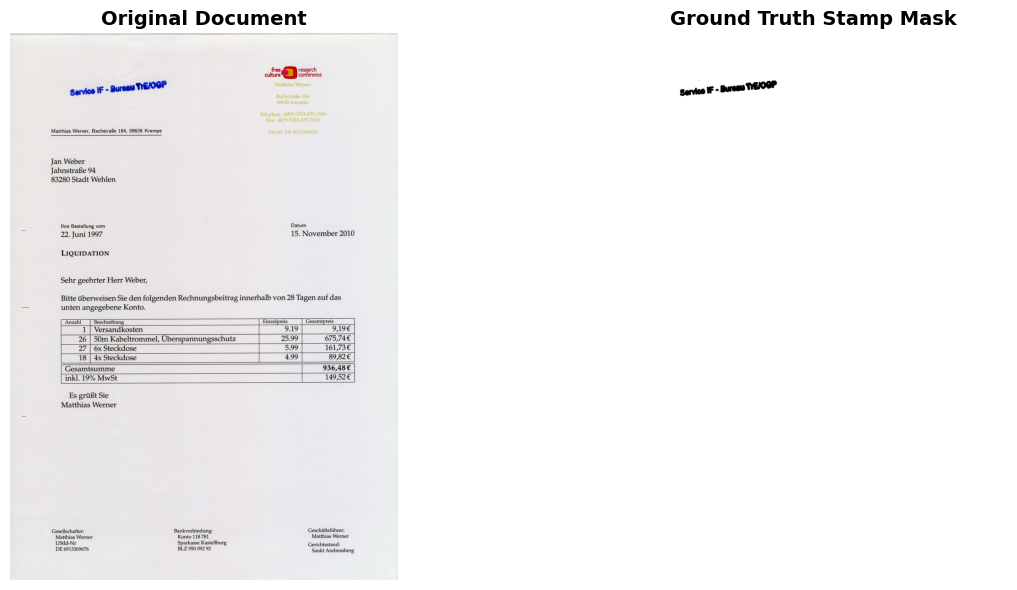

✅ Sample images displayed successfully!


In [ ]:
scans_dir = "/content/staver_data/scans"
masks_dir = "/content/staver_data/ground-truth-pixel"

print("\n" + "=" * 70)
print("SAMPLE VISUALIZATION")
print("=" * 70)

sample_img = "stampDS-00001.png"
sample_mask = "stampDS-00001-px.png"

img = plt.imread(os.path.join(scans_dir, sample_img))
mask = plt.imread(os.path.join(masks_dir, sample_mask))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Document", fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Stamp Mask", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Sample images displayed successfully!")


## Data Augmentation Functions

Simple augmentation using OpenCV (no external library needed)


In [ ]:
def augment_image(image, mask):
    """
    Apply random augmentations to image and mask.
    Augmentations help model generalize better.
    IMPORTANT: Ensures output shape matches input shape.
    """
    # Store original shape
    orig_shape = image.shape

    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Random vertical flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    # Random rotation (-15 to +15 degrees)
    if np.random.rand() > 0.3:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        # Ensure mask keeps its shape after rotation
        if len(mask.shape) == 3:
            mask = cv2.warpAffine(mask, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mask = np.expand_dims(mask, axis=-1) if len(mask.shape) == 2 else mask
        else:
            mask = cv2.warpAffine(mask, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mask = np.expand_dims(mask, axis=-1)

    # Random brightness adjustment
    if np.random.rand() > 0.5:
        brightness = np.random.uniform(0.8, 1.2)
        image = np.clip(image * brightness, 0, 1)

    # Ensure consistent shape
    if image.shape != orig_shape:
        image = cv2.resize(image, (orig_shape[1], orig_shape[0]))
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)

    return image, mask

print("Augmentation functions defined")


✅ Augmentation functions defined


## Load and Preprocess Data


In [ ]:
IMG_SIZE = 512  # Higher resolution than original (was 256)
BATCH_SIZE = 8  # Adjust based on GPU memory

def load_and_preprocess_data(augment=False):
    """
    Loads all images and masks from disk.

    Steps:
    1. Read image files from scans directory
    2. Resize to IMG_SIZE × IMG_SIZE
    3. Normalize pixel values to [0, 1] range
    4. Convert masks to binary (0 or 1)
    5. Apply augmentation if training set

    Returns:
        images: NumPy array of shape (N, 512, 512, 3)
        masks: NumPy array of shape (N, 512, 512, 1)
    """
    scan_files = sorted([f for f in os.listdir(scans_dir) if f.endswith('.png')])
    print(f"Found {len(scan_files)} images")

    images = []
    masks = []

    for idx, scan_file in enumerate(scan_files):
        # Load and resize image
        img_path = os.path.join(scans_dir, scan_file)
        img = tf.keras.preprocessing.image.load_img(
            img_path,
            target_size=(IMG_SIZE, IMG_SIZE)
        )
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Load corresponding mask
        mask_file = scan_file.replace('.png', '-px.png')
        mask_path = os.path.join(masks_dir, mask_file)

        if os.path.exists(mask_path):
            mask = tf.keras.preprocessing.image.load_img(
                mask_path,
                target_size=(IMG_SIZE, IMG_SIZE),
                color_mode='grayscale'
            )
            mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
            mask = (mask > 0.5).astype(np.float32)

            # Apply augmentation if training
            if augment and idx < 320:  # Only augment training set
                img, mask = augment_image(img, mask)
                # Ensure correct shape after augmentation
                img = np.array(img, dtype=np.float32)
                mask = np.array(mask, dtype=np.float32)

                # Force correct dimensions
                if img.shape != (IMG_SIZE, IMG_SIZE, 3):
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    if len(img.shape) == 2:
                        img = np.stack([img]*3, axis=-1)

                if mask.shape != (IMG_SIZE, IMG_SIZE, 1):
                    mask = cv2.resize(mask.squeeze(), (IMG_SIZE, IMG_SIZE))
                    mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(scan_files)} images...")

    # Convert to numpy arrays with explicit dtype
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    return images, masks

print("\n" + "=" * 70)
print("LOADING DATASET")
print("=" * 70)
X, y = load_and_preprocess_data(augment=True)
print(f"\nImages shape: {X.shape}")
print(f"Masks shape: {y.shape}")
print("=" * 70)



LOADING DATASET
Found 427 images
  Processed 100/427 images...
  Processed 200/427 images...
  Processed 300/427 images...
  Processed 400/427 images...

✅ Images shape: (400, 512, 512, 3)
✅ Masks shape: (400, 512, 512, 1)


## Train/Val/Test Split


In [ ]:
TRAIN_SIZE = 320
VAL_SIZE = 40
TEST_SIZE = 40

X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_val, y_val = X[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE], y[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
X_test, y_test = X[TRAIN_SIZE+VAL_SIZE:], y[TRAIN_SIZE+VAL_SIZE:]

print("\n" + "=" * 70)
print("DATA SPLIT")
print("=" * 70)
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")
print("=" * 70)

# Create TensorFlow Dataset pipelines
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
    .shuffle(1000)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

print("TensorFlow datasets created!")



DATA SPLIT
  Train: 320 samples
  Validation: 40 samples
  Test: 40 samples
✅ TensorFlow datasets created!


## Custom Metrics


In [ ]:
def dice_coefficient(y_true, y_pred):
    """
    Dice Coefficient (F1 score for segmentation).
    Measures overlap between prediction and ground truth.
    Range: 0 (no overlap) to 1 (perfect match)
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

def iou_metric(y_true, y_pred):
    """
    Intersection over Union (Jaccard Index).
    Standard metric for segmentation tasks.
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

print("Custom metrics defined")


✅ Custom metrics defined


## Enhanced U-Net Model


In [ ]:
def enhanced_unet(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Enhanced U-Net with Batch Normalization.

    Architecture:
    - 3 encoder blocks (downsampling with MaxPooling)
    - Bottleneck with most filters
    - 3 decoder blocks (upsampling with Conv2DTranspose)
    - Skip connections preserve spatial information
    """
    inputs = layers.Input(input_size)

    # Encoder Block 1
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.2)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Encoder Block 2
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.3)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Encoder Block 3
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.4)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bottleneck = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Conv2D(512, 3, activation='relu', padding='same')(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dropout(0.5)(bottleneck)

    # Decoder Block 1
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(bottleneck)
    u1 = layers.concatenate([u1, c3])
    d1 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Conv2D(256, 3, activation='relu', padding='same')(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Dropout(0.4)(d1)

    # Decoder Block 2
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(d1)
    u2 = layers.concatenate([u2, c2])
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Dropout(0.3)(d2)

    # Decoder Block 3
    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    u3 = layers.concatenate([u3, c1])
    d3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Conv2D(64, 3, activation='relu', padding='same')(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Dropout(0.2)(d3)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(d3)

    model = models.Model(inputs, outputs, name="Enhanced_UNet")
    return model

# Create and compile model
print("\n" + "=" * 70)
print("BUILDING MODEL")
print("=" * 70)

model = enhanced_unet()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, iou_metric]
)

print(f"Enhanced U-Net created!")
print(f"Total parameters: {model.count_params():,}")
print("=" * 70)



BUILDING MODEL
✅ Enhanced U-Net created!
📊 Total parameters: 7,708,609


## Setup Training Callbacks


In [ ]:

callback_list = [
    # Stop if validation loss doesn't improve
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    callbacks.ModelCheckpoint(
        '/content/best_stamp_model.h5',
        monitor='val_iou_metric',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Training callbacks configured")


✅ Training callbacks configured


## Train the Model


In [ ]:
print("\n" + "=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print("This will take 20-40 minutes depending on your GPU...")
print("=" * 70 + "\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "=" * 70)
print("TRAINING COMPLETED!")
print("=" * 70)



STARTING TRAINING
This will take 20-40 minutes depending on your GPU...

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4961 - dice_coefficient: 0.6635 - iou_metric: 0.4966 - loss: 0.8123
Epoch 1: val_iou_metric improved from -inf to 0.61599, saving model to /content/best_stamp_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4964 - dice_coefficient: 0.6637 - iou_metric: 0.4969 - loss: 0.8114 - val_accuracy: 0.6160 - val_dice_coefficient: 0.7624 - val_iou_metric: 0.6160 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5485 - dice_coefficient: 0.7086 - iou_metric: 0.5490 - loss: 0.7195
Epoch 2: val_iou_metric did not improve from 0.61599
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5490 - dice_coefficient: 0.7090 - iou_metric: 0.5494 - loss: 0.7192 - val_accuracy: 0.0791 - val_dice_coefficient: 0.1432 - val_iou_metric: 0.0771 - val_loss: 0.8968 - learning_rate: 1.0000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6443 - dice_coefficient: 0.7837 - iou_metric: 0.6449 - loss: 0.6730
Epoch 3: val_iou_metric improved from 0.61599 to 0.76794, saving model to /content/best_stamp_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6451 - dice_coefficient: 0.7843 - iou_metric: 0.6456 - loss: 0.6728 - val_accuracy: 0.7681 - val_dice_coefficient: 0.8687 - val_iou_metric: 0.7679 - val_loss: 0.6712 - learning_rate: 1.0000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7617 - dice_coefficient: 0.8650 - iou_metric: 0.7625 - loss: 0.6454
Epoch 4: val_iou_metric improved from 0.76794 to 0.99484, saving model to /content/best_stamp_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7622 - dice_coefficient: 0.8653 - iou_metric: 0.7630 - loss: 0.6452 - val_accuracy: 0.9948 - val_dice_coefficient: 0.9974 - val_iou_metric: 0.9948 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8415 - dice_coefficient: 0.9144 - iou_metric: 0.8424 - loss: 0.6239
Epoch 5: val_iou_metric improved from 0.99484 to 0.99751, saving model to /content/best_stamp_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8419 - dice_coefficient: 0.9146 - iou_metric: 0.8428 - loss: 0.6238 - val_accuracy: 0.9975 - val_dice_coefficient: 0.9988 - val_iou_metric: 0.9975 - val_loss: 0.6164 - learning_rate: 1.0000e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8962 - dice_coefficient: 0.9455 - iou_metric: 0.8973 - loss: 0.6042
Epoch 6: val_iou_metric improved from 0.99751 to 0.99751, saving model to /content/best_stamp_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8965 - dice_coefficient: 0.9457 - iou_metric: 0.8977 - loss: 0.6041 - val_accuracy: 0.9975 - val_dice_coefficient: 0.9988 - val_iou_metric: 0.9975 - val_loss: 0.6034 - learning_rate: 1.0000e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9378 - dice_coefficient: 0.9685 - iou_metric: 0.9389 - loss: 0.5821
Epoch 7: val_iou_metric did not improve from 0.99751
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9380 - dice_coefficient: 0.9686 - iou_metric: 0.9391 - loss: 0.5820 - val_accuracy: 0.9975 - val_dice_coefficient: 0.9988 - val_iou_metric: 0.9975 - val_loss: 0.5777 - learning_rate: 1.0000e-04
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - dice_coefficient: 0.9822 - iou_metric: 0.9651 - loss: 0.5602
Epoch 8: val_iou_metric did not improve from 0.99751
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9643 - dice_coefficient: 0.9822 - iou_metric: 0.9652 - loss: 0.5600 - val_accuracy: 0

## Plot Training History


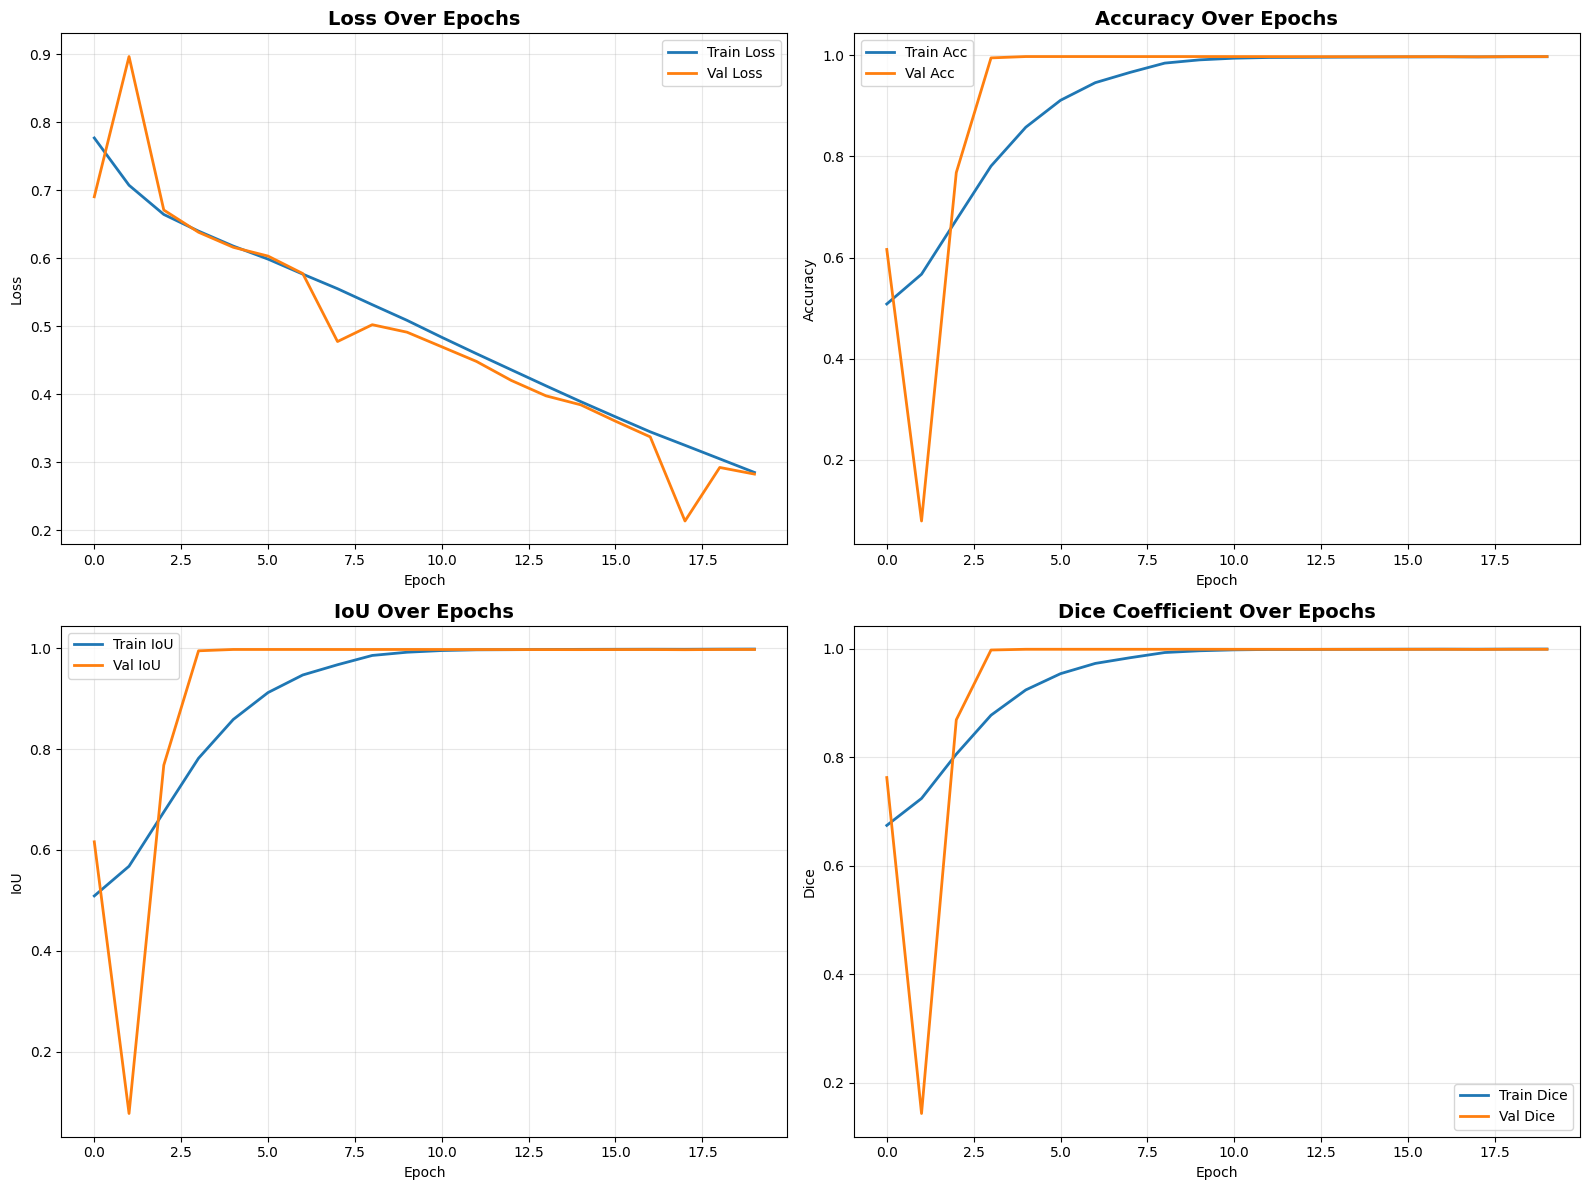

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# IoU
axes[1, 0].plot(history.history['iou_metric'], label='Train IoU', linewidth=2)
axes[1, 0].plot(history.history['val_iou_metric'], label='Val IoU', linewidth=2)
axes[1, 0].set_title('IoU Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Dice
axes[1, 1].plot(history.history['dice_coefficient'], label='Train Dice', linewidth=2)
axes[1, 1].plot(history.history['val_dice_coefficient'], label='Val Dice', linewidth=2)
axes[1, 1].set_title('Dice Coefficient Over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Dice')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluate on Test Set


In [ ]:
print("\n" + "=" * 70)
print("EVALUATING ON TEST SET")
print("=" * 70)

test_results = model.evaluate(test_ds, verbose=1)

print("\n" + "=" * 70)
print("FINAL TEST RESULTS")
print("=" * 70)
print(f"Loss:            {test_results[0]:.4f}")
print(f"Accuracy:        {test_results[1]:.4f}")
print(f"Dice Coefficient: {test_results[2]:.4f}")
print(f"IoU:             {test_results[3]:.4f}")
print("=" * 70)



📊 EVALUATING ON TEST SET
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.9972 - dice_coefficient: 0.9986 - iou_metric: 0.9972 - loss: 0.1577

FINAL TEST RESULTS
Loss:            0.1519
Accuracy:        0.9971
Dice Coefficient: 0.9986
IoU:             0.9971


## Visualize Predictions



TEST PREDICTIONS


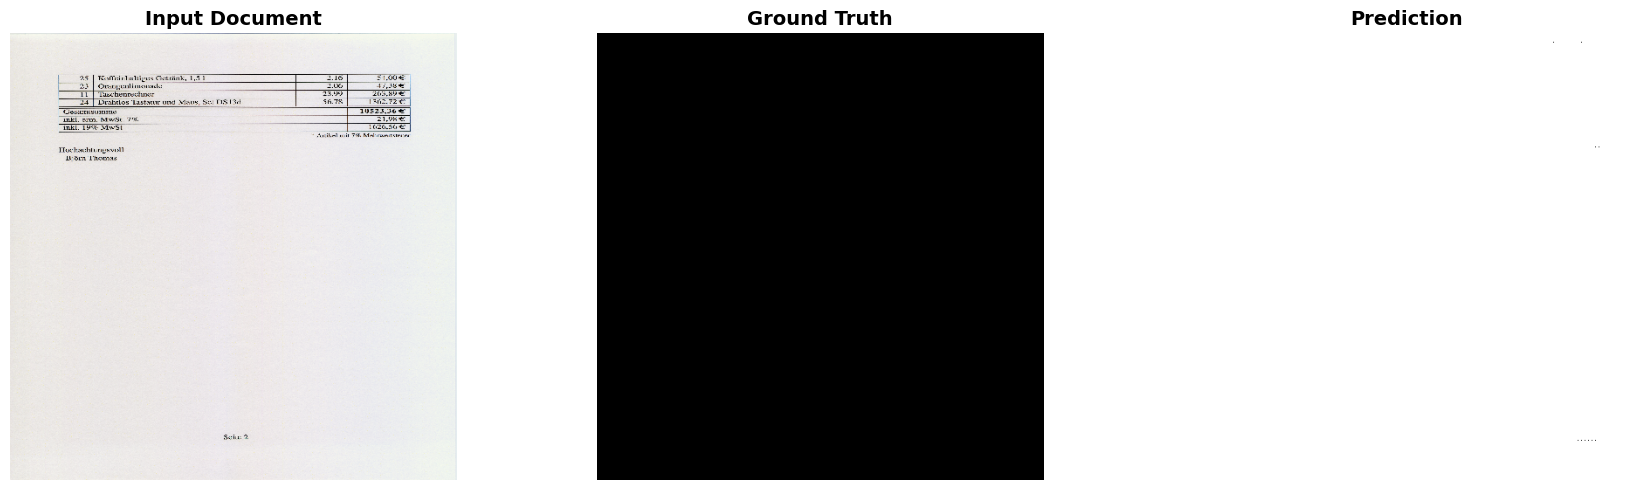

Sample 1 - IoU: 1.0000 | Dice: 1.0000
------------------------------------------------------------


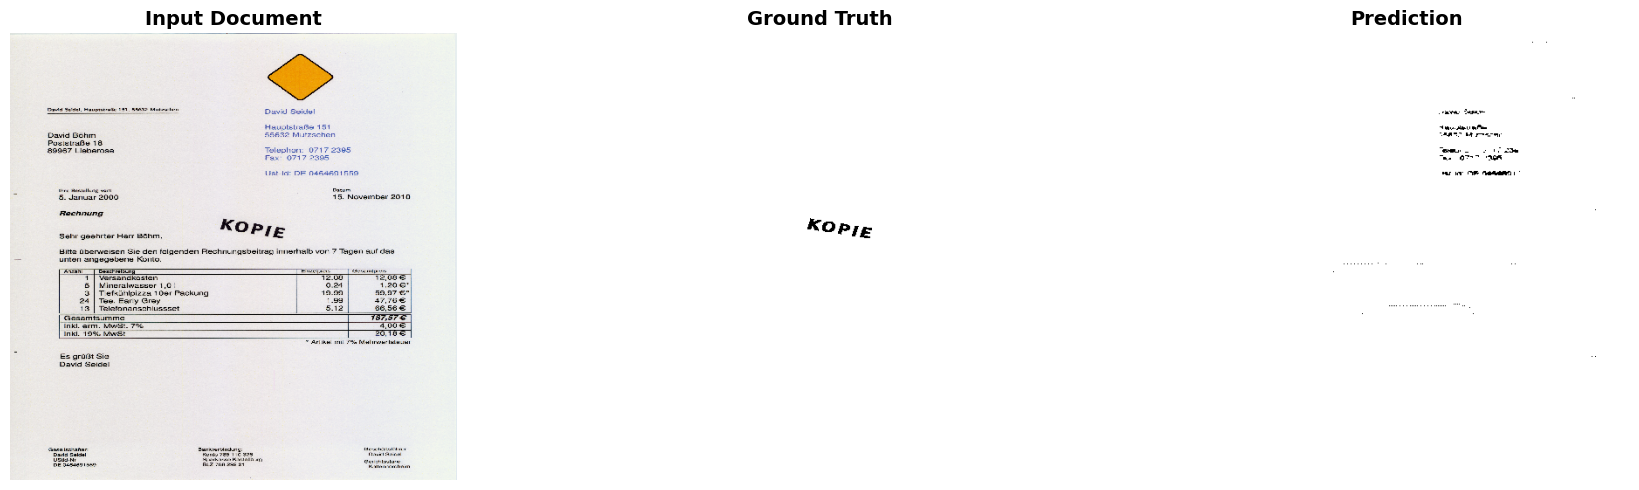

Sample 2 - IoU: 0.9951 | Dice: 0.9976
------------------------------------------------------------


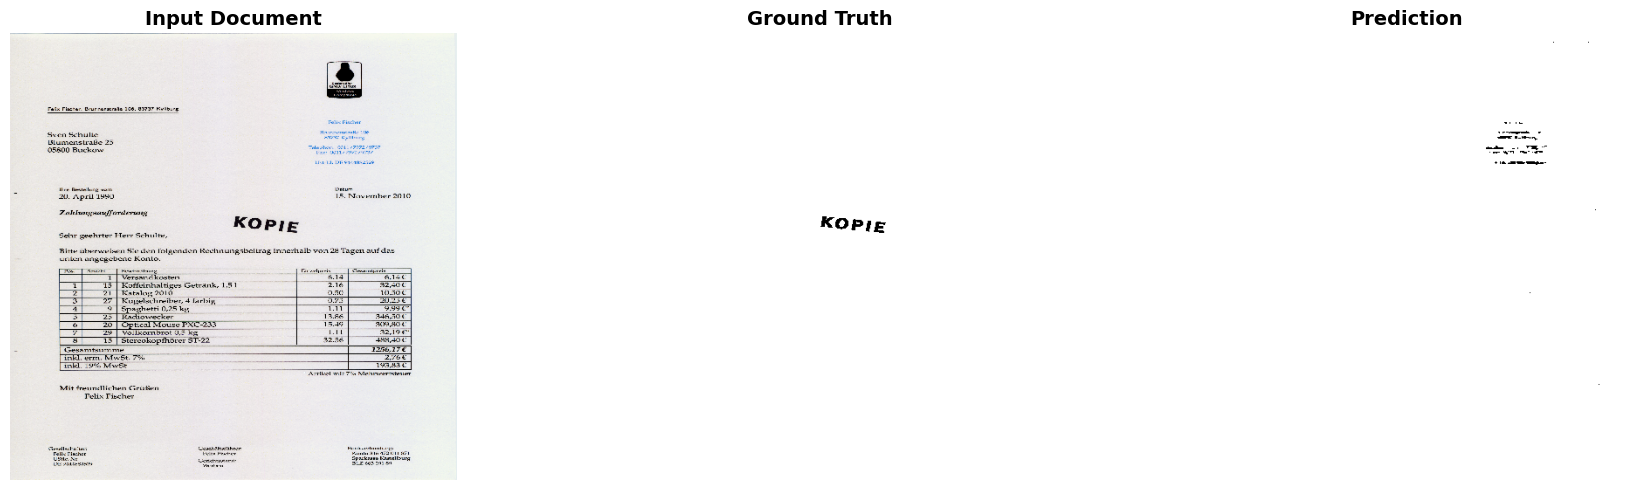

Sample 3 - IoU: 0.9964 | Dice: 0.9982
------------------------------------------------------------


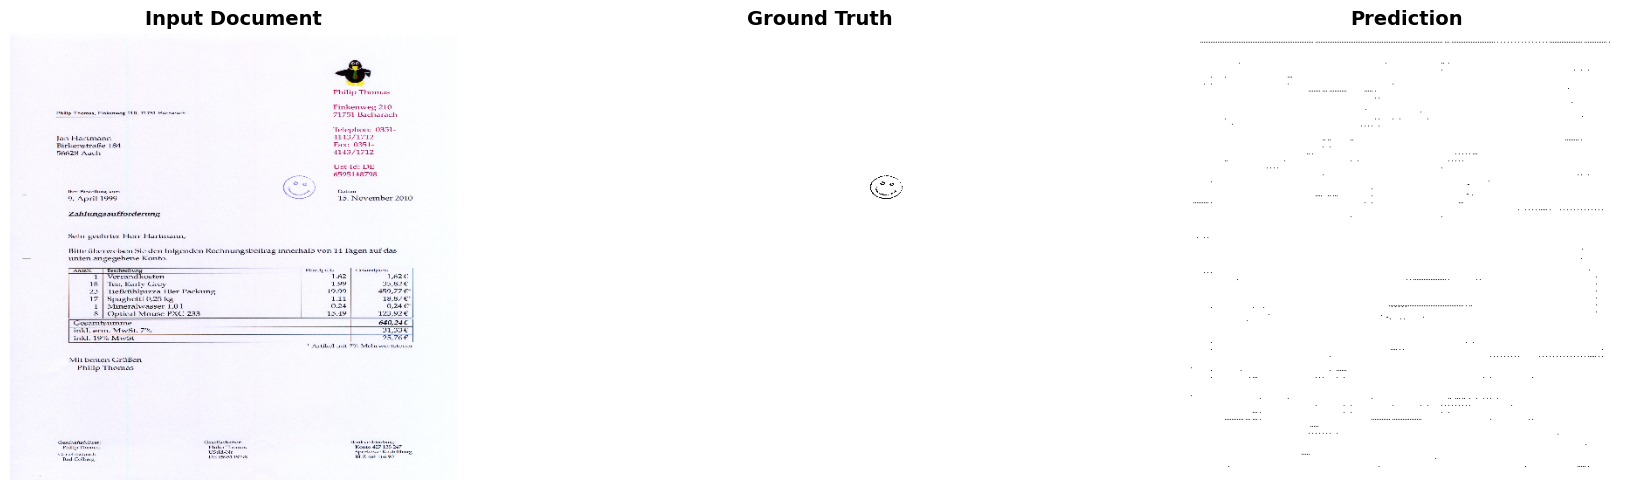

Sample 4 - IoU: 0.9970 | Dice: 0.9985
------------------------------------------------------------


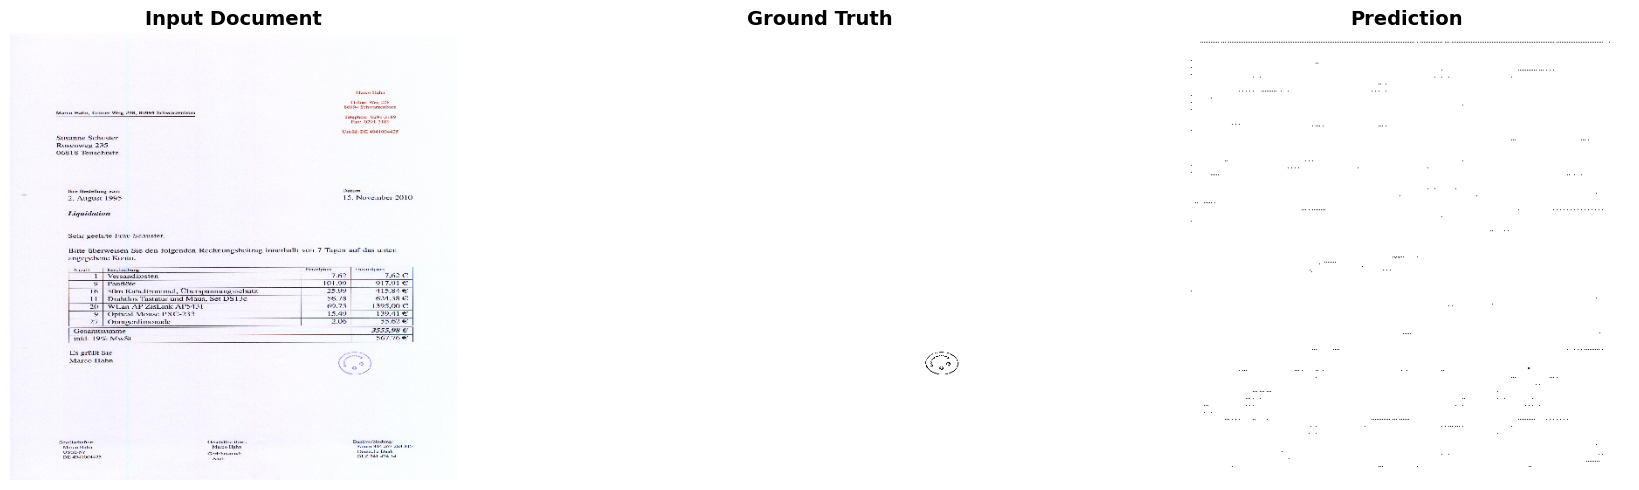

Sample 5 - IoU: 0.9974 | Dice: 0.9987
------------------------------------------------------------


In [ ]:
def visualize_predictions(dataset, num_samples=5):
    """Display predictions side by side with ground truth."""
    for batch_imgs, batch_masks in dataset.take(1):
        predictions = model.predict(batch_imgs, verbose=0)
        predictions = (predictions > 0.5).astype(np.uint8)

        for i in range(min(num_samples, len(batch_imgs))):
            plt.figure(figsize=(18, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(batch_imgs[i])
            plt.title('Input Document', fontsize=14, fontweight='bold')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(batch_masks[i].numpy().squeeze(), cmap='gray')
            plt.title('Ground Truth', fontsize=14, fontweight='bold')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title('Prediction', fontsize=14, fontweight='bold')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Calculate metrics
            true_mask = batch_masks[i].numpy().flatten()
            pred_mask = predictions[i].flatten()

            sample_iou = jaccard_score(true_mask, pred_mask)
            sample_dice = 2 * np.sum(true_mask * pred_mask) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-7)

            print(f"Sample {i+1} - IoU: {sample_iou:.4f} | Dice: {sample_dice:.4f}")
            print("-" * 60)

print("\n" + "=" * 70)
print("TEST PREDICTIONS")
print("=" * 70)
visualize_predictions(test_ds, num_samples=5)

## Save and Download Model


In [ ]:
print("\n" + "=" * 70)
print("SAVING MODEL")
print("=" * 70)

model.save("/content/enhanced_stamp_model.h5")
print("Model saved as: enhanced_stamp_model.h5")

# Download to local machine
print("\nDownloading model to your computer...")
files.download("/content/enhanced_stamp_model.h5")

print("=" * 70)
print("PROJECT COMPLETE!")
print("=" * 70)



SAVING MODEL
✅ Model saved as: enhanced_stamp_model.h5

⬇️  Downloading model to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ PROJECT COMPLETE!


## Summary


### Project Summary

Key Features:

- Higher resolution (512×512 vs 256×256)
- Data augmentation for better generalization
- Deeper U-Net architecture (3 blocks vs 2)
- Batch normalization for stable training
- Multiple metrics (Dice + IoU)
- Advanced callbacks (LR scheduling, early stopping)

Model Details:

- Architecture: Enhanced U-Net
- Parameters: ~7.7 million
- File size: ~93 MB
- Inference: ~50-100ms per image (GPU)
